In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import wrangle

## Acquire Data

Data acquired from 'zillow' database. Looking at the available rows and running a few basic queries in MySQL, the following decisions were made:
- bathroomcnt and bedroomcnt will be used
  - calculatedbathnbr and threequarterbathnbr had many nulls
  - roomcnt was primarily zeros and its meaning is unclear.  this could be pursued in future analyses
- taxamount won't be pulled in as it is calculated off of tax value, our target variable
- regionidzip and fips will be used
  - regionidneighborhood was half nulls and barely had more distinct entries than regionidzip


In [2]:
#Write some SQL - expect 52441 rows
sql = """
SELECT bedroomcnt as bed,
    bathroomcnt as bath, 
    calculatedfinishedsquarefeet as sf, 
    taxvaluedollarcnt as value, 
    yearbuilt, 
    assessmentyear,
    regionidzip as zipcode, 
    fips
FROM properties_2017
    JOIN propertylandusetype USING(propertylandusetypeid)
    JOIN predictions_2017 USING(parcelid)
WHERE propertylandusedesc = 'Single Family Residential' AND transactiondate LIKE '2017%%';
"""

In [3]:
df = df_backup = pd.read_sql(sql,wrangle.get_db_url('zillow'))

In [4]:
df.shape #rows match

(52441, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             52441 non-null  float64
 1   bath            52441 non-null  float64
 2   sf              52359 non-null  float64
 3   value           52440 non-null  float64
 4   yearbuilt       52325 non-null  float64
 5   assessmentyear  52441 non-null  float64
 6   zipcode         52415 non-null  float64
 7   fips            52441 non-null  float64
dtypes: float64(8)
memory usage: 3.2 MB


## Prepare Data
### Investigating Nulls

(array([ 3.,  0.,  0.,  0.,  0., 78.,  0.,  0.,  0., 60.]),
 array([5. , 5.2, 5.4, 5.6, 5.8, 6. , 6.2, 6.4, 6.6, 6.8, 7. ]),
 <BarContainer object of 10 artists>)

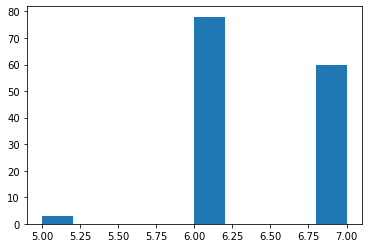

In [6]:
#let's check out how the nulls overlap
#Count how many values we have per row
hist = df.count(axis=1,numeric_only=False)
plt.hist(hist[hist<8])

Looking at the above, a decent number of these are only missing one or two pieces of data. However, since we are still only looking at ~140 total rows, I am going to go ahead and drop them all. Ideally, I'd check some of this with stakeholders. My primary concern is that we may be inadvertently trimming a particular geographic area (perhaps one with poor reporting on year built and zip code)

**ACTION:** Drop all nulls

In [7]:
df.dropna(inplace=True)
df.shape

(52300, 8)

### Look at the distributions of each feature

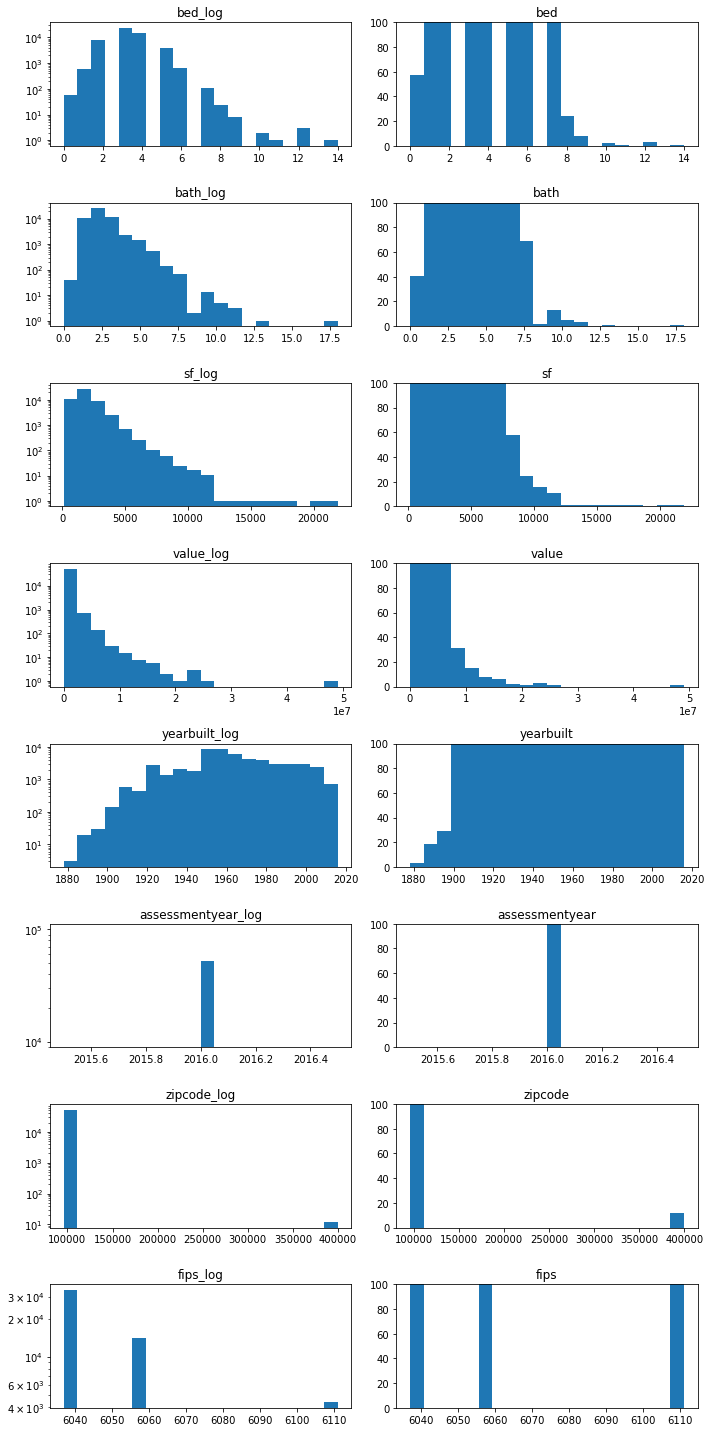

In [8]:
#See on logarythmic scale to better see outliers
plt.figure(figsize=(10,20))
ct=0
for c in df.columns:
    ct +=1
    plt.subplot(8,2,ct)
    plt.hist(df[c],bins=20)
    plt.title(c+'_log')
    plt.yscale('log')
    ct +=1
    plt.subplot(8,2,ct)
    plt.hist(df[c],bins=20)
    plt.title(c)
    plt.ylim((0,100))
    
plt.tight_layout()

Definitely some bed, bath, sf, value, assessment year and year outliers. I don't want to snap any values in. 

- Since Zillow estimates are not expected to be utilized by the top 1%, I want to cut some of the expensive and large houses. We'll cut the top .1% of sf homes off the dataset. NOTE: I recognized that sf is being used as a proxy for value, but it's one method of avoiding trimming by our target so that we can better specify how the model was trained in a useful manner
- Since the data is skewed right, I want to trim less off the left. After considering a few different cutoffs, I found that california code restricts minimum dwelling size to 120 sq ft.
  - "Every dwelling unit shall have at least one room that shall have not less than 120 square feet (13.9 m2) of net floor area"
  
**ACTION:** Drop rows with the top .1% of sf or an sf of less than 120

In [9]:
#drop top 1% of sf
df = df[df.sf<df.sf.quantile(.999)]

#drop anything less than 120 sf
df = df[df.sf>=120]
df.shape

(52247, 8)

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bed,52247.0,3.302525,0.934074,0.0,3.0,3.0,4.0,12.0
bath,52247.0,2.296620,1.000205,0.0,2.0,2.0,3.0,10.0
sf,52247.0,1912.633874,953.584381,128.0,1267.0,1657.0,2302.0,9065.0
value,52247.0,519589.264111,656123.544888,1000.0,193455.5,373000.0,616885.5,25381250.0
yearbuilt,52247.0,1963.358872,23.106353,1878.0,1950.0,1960.0,1979.0,2016.0
assessmentyear,52247.0,2016.000000,0.000000,2016.0,2016.0,2016.0,2016.0,2016.0
zipcode,52247.0,96636.005857,4612.438539,95982.0,96206.0,96412.0,96995.0,399675.0
fips,52247.0,6049.088771,20.982728,6037.0,6037.0,6037.0,6059.0,6111.0


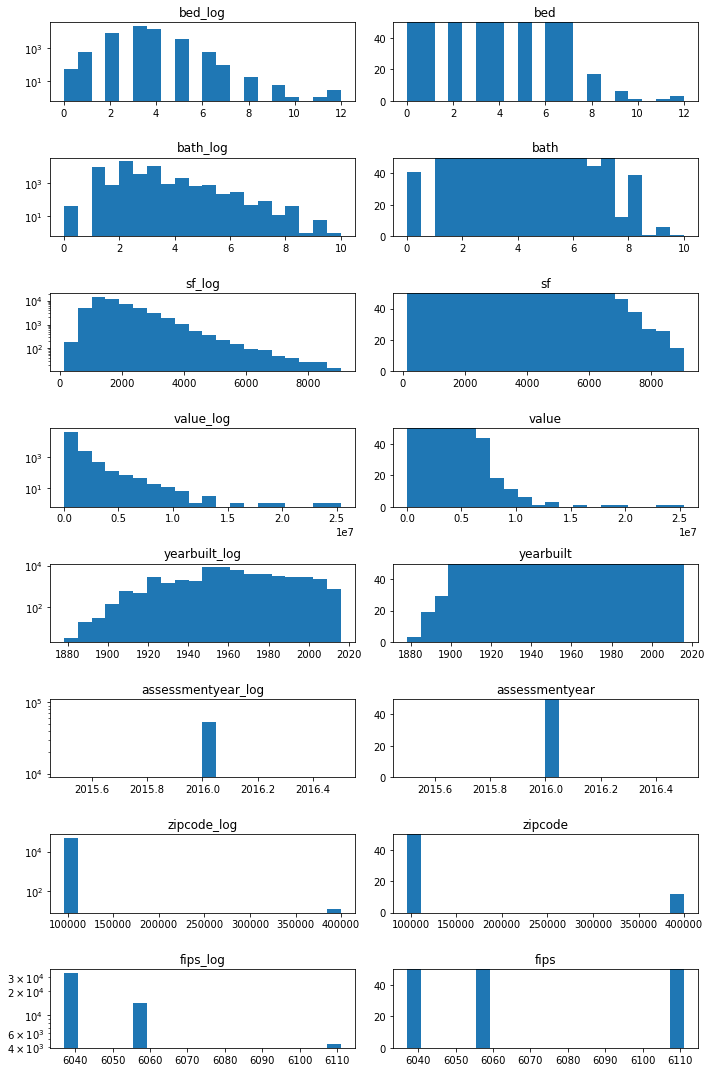

In [11]:
#Plot again
plt.figure(figsize=(10,15))
ct=0
for c in df.columns:
    ct +=1
    plt.subplot(8,2,ct)
    plt.hist(df[c],bins=20)
    plt.title(c+'_log')
    plt.yscale('log')
    ct +=1
    plt.subplot(8,2,ct)
    plt.hist(df[c],bins=20)
    plt.title(c)
    plt.ylim((0,50))
    
plt.tight_layout()

Even after using sf trimming, we still have quite a few outliers in each category. Because of that, I'll do more trimming on the high side. Since Zillow's target customers aren't the super rich, I feel comfortable trimming 9+ bedrooms, 9+ bathrooms and 5+ million value. While we wanted to avoid any triming by value, it is import to get rid of these extreme outliers.

In [12]:
df[df.bed > 8].shape

(11, 8)

In [13]:
df[df.bath>8].shape

(8, 8)

In [14]:
df[df.value>2_000_000].shape

(1323, 8)

In [15]:
#see percent that fall in this category
df[(df.value>2_000_000) | (df.bath >8) | (df.bed >8)].shape[0] / df.shape[0]

0.02547514689838651

Even with the extra trimming, that only accounts for 2.5% of the data. and most of this came from the price cutoff.

**Action:** Drop all rows with 9+ beds, 9+ baths, or a value of 2+ million.



In [16]:
df = df[(df.value < 2_000_000) & (df.bath < 9) & (df.bed <9)]
df.shape

(50915, 8)

Zero baths don't make much sense for a single family home.  

In [17]:
df[df.bath==0].shape

(39, 8)

**Action:** Only ~40 rows, drop anything with zero baths.

In [18]:
df = df[df.bath>0]
df.shape

(50876, 8)

Now let's look at assessment year & zip code

In [19]:
df.assessmentyear.value_counts()

2016.0    50876
Name: assessmentyear, dtype: int64

Since there was a transaction it looks to have a current assessment.

**ACTION:** Drop the assessment year column

In [20]:
df.zipcode.value_counts()

97319.0    774
97318.0    670
97329.0    564
97328.0    519
97118.0    496
          ... 
95996.0      2
97092.0      1
96038.0      1
96148.0      1
96467.0      1
Name: zipcode, Length: 380, dtype: int64

(0.0, 100.0)

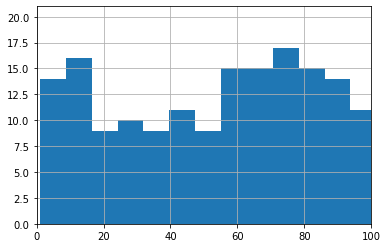

In [21]:
#see if we don't have enough zipcode information for some
df.zipcode.value_counts().hist(bins=100)
plt.xlim(0,100)

There are a few zip codes with very few datapoints. 

**ACTION:** Drop all rows with a zip code that has less than 50 other properties in that zip code.



In [22]:
zip_cnt = df.zipcode.value_counts()
zip_cnt

97319.0    774
97318.0    670
97329.0    564
97328.0    519
97118.0    496
          ... 
95996.0      2
97092.0      1
96038.0      1
96148.0      1
96467.0      1
Name: zipcode, Length: 380, dtype: int64

In [23]:
zip_cnt[zip_cnt < 30].sum()/df_backup.shape[0] #1.3% of total dataset

0.012944550669216062

In [24]:
drp_zips = zip_cnt[zip_cnt < 30].index
drp_zips

Float64Index([ 96010.0,  96979.0,  96136.0,  96014.0,  97109.0,  96133.0,
               95987.0,  96150.0,  96236.0,  96019.0,  96973.0,  96087.0,
               96216.0,  96128.0,  95986.0,  96275.0,  96986.0,  96021.0,
               96119.0,  96088.0,  96009.0,  96951.0,  96234.0,  96001.0,
               95993.0,  97324.0,  97119.0,  95994.0,  97331.0,  95995.0,
               96151.0,  96980.0,  96322.0,  95988.0, 399675.0,  96207.0,
               96289.0,  97108.0,  96226.0,  96039.0,  96002.0,  96323.0,
               96434.0,  95996.0,  97092.0,  96038.0,  96148.0,  96467.0],
             dtype='float64')

**WARNING:** I looked up some of these zip codes, and they do not correspond to the fips (counties) that are in this dataset.  Looking at the metadata, it states that these *should* be zip codes.  I will keep this info for now, as there is no reason to assume it is less or more valid than the fips.  It is possible it is another geographic identifier unique to zillow.

Ideally, I would import this information into ArcGIS and plot the lat/lon of these properties and colorize them by the 'regionidzip'.  This would help to confirm they are geographic properties.

In [25]:
df.shape

(50876, 8)

In [26]:
#drop the rows with those zip codes
df = df[df.zipcode.isin(drp_zips)==False]
df.shape

(50199, 8)

### Check dataypes are appropriate

In [27]:
df.bed.value_counts() #can be integer

3.0    22805
4.0    14666
2.0     8064
5.0     3534
1.0      539
6.0      502
7.0       68
0.0       12
8.0        9
Name: bed, dtype: int64

In [28]:
(df.yearbuilt % 1).value_counts() # can be integer

0.0    50199
Name: yearbuilt, dtype: int64

In [29]:
(df.sf %1).value_counts() # can be integer

0.0    50199
Name: sf, dtype: int64

In [30]:
(df.value %1).value_counts() # can be integer

0.0    50199
Name: value, dtype: int64

In [31]:
df[df.zipcode % 1 != 0] #good, all zips are whole numbers.  convert to string

,bed,bath,sf,value,yearbuilt,assessmentyear,zipcode,fips


While sf and value can be floats, realistically they rarely are and the partial sf and dollars wouldn't matter.

**ACTION:** Round down sf and value, then convert bed, yearbuilt, sf, value and zipcode to integers.

In [32]:
df.bed = df.bed.astype(int)
df.yearbuilt = df.yearbuilt.astype(int)
#astype automatically rounds floats
df.sf = df.sf.astype(int)
df.value = df.value.astype(int)
#int first to get rid of the ".0" then to string
df.zipcode = df.zipcode.astype(int).astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50199 entries, 0 to 52440
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             50199 non-null  int64  
 1   bath            50199 non-null  float64
 2   sf              50199 non-null  int64  
 3   value           50199 non-null  int64  
 4   yearbuilt       50199 non-null  int64  
 5   assessmentyear  50199 non-null  float64
 6   zipcode         50199 non-null  object 
 7   fips            50199 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 3.4+ MB


### Now create a new feature 

I want a new column that is squarefeet per # of bedrooms.

Since the number of rooms is likely related to the squarefootage, I want to try and create a combined column.  Because bathrooms are generally much smaller than bedrooms, I don't want to include that in the numerator.  

Any rows with zero bedrooms will be treated as having one bedroom. 

In [33]:
#create sf per bed column, consider 0 beds to have 1 bedroom (EX: studio)
for i in df.index:
    #for each row do math of sf/bed.  If bed is zero, use 1
    df.loc[i,'sf_per_bed'] = df.loc[i,'sf']/ max(1,df.loc[i,'bed'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50199 entries, 0 to 52440
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             50199 non-null  int64  
 1   bath            50199 non-null  float64
 2   sf              50199 non-null  int64  
 3   value           50199 non-null  int64  
 4   yearbuilt       50199 non-null  int64  
 5   assessmentyear  50199 non-null  float64
 6   zipcode         50199 non-null  object 
 7   fips            50199 non-null  float64
 8   sf_per_bed      50199 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 4.8+ MB


In [34]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bed,50199.0,3.286440,0.902011,0.0,3.0,3.0,4.0,8.0
bath,50199.0,2.246917,0.912667,1.0,2.0,2.0,3.0,8.0
sf,50199.0,1853.612263,837.447508,152.0,1262.0,1639.0,2246.5,8615.0
value,50199.0,445211.315923,353927.105025,1000.0,189503.0,364675.0,590000.0,1997251.0
yearbuilt,50199.0,1963.366163,22.609333,1878.0,1950.0,1961.0,1978.0,2016.0
assessmentyear,50199.0,2016.000000,0.000000,2016.0,2016.0,2016.0,2016.0,2016.0
fips,50199.0,6049.235981,21.117635,6037.0,6037.0,6037.0,6059.0,6111.0
sf_per_bed,50199.0,565.081551,194.090872,30.4,427.5,524.0,654.0,3494.0


(0.0, 2000.0)

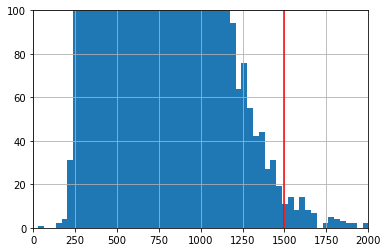

In [35]:
df.sf_per_bed.hist(bins=100)
plt.axvline(x=1500,c='r')
plt.ylim(0,100)
plt.xlim(0,2000)

In [36]:
df[df.sf_per_bed < 200]
#looks like we have an outlier - likely typo - index #48784

,bed,bath,sf,value,yearbuilt,assessmentyear,zipcode,fips,sf_per_bed
3259,4,1.0,780,15890,1941,2016.0,96398,6037.0,195.0
25862,5,1.0,952,913725,1950,2016.0,96117,6037.0,190.4
32168,2,1.0,326,16084,1932,2016.0,96398,6037.0,163.0
34640,4,2.0,622,110943,1945,2016.0,96957,6059.0,155.5
39645,4,1.0,744,87119,1927,2016.0,96040,6037.0,186.0
46917,4,1.0,780,13199,1905,2016.0,95982,6037.0,195.0
48786,5,2.0,152,314726,1982,2016.0,95983,6037.0,30.4


In [37]:
df[df.sf_per_bed >=1500]

,bed,bath,sf,value,yearbuilt,assessmentyear,zipcode,fips,sf_per_bed
362,3,3.0,4610,543003,1978,2016.0,96122,6037.0,1536.666667
974,1,2.0,1524,689674,1924,2016.0,96109,6037.0,1524.000000
994,2,3.0,3678,1561352,1932,2016.0,96016,6037.0,1839.000000
1375,1,3.0,1619,1664376,1949,2016.0,96116,6037.0,1619.000000
1566,2,3.0,3230,954106,1967,2016.0,97005,6059.0,1615.000000
...,...,...,...,...,...,...,...,...,...
51339,1,2.0,2508,183902,1958,2016.0,96956,6059.0,2508.000000
51349,3,4.0,4530,1900000,1987,2016.0,96387,6037.0,1510.000000
51599,1,1.0,2544,115469,1979,2016.0,97323,6037.0,2544.000000
51697,3,3.5,5774,494013,1975,2016.0,96384,6111.0,1924.666667


**ACTION:** Drop the significant outliers in this column.  sf_per_bed < 100 and sf_per_bed >= 1500

In [38]:
df = df[(df.sf_per_bed>99) & (df.sf_per_bed<1500)] 

### Now encode the categorical variables, drop and reorder columns

In [39]:
#I want to map then encode so that I have common sense 
# names for EDA and easy to read columns for the model

#map to county names
df['county'] = df.fips.map({6037: 'LosAngeles_CA',6059:'Orange_CA',6111:'Ventura_CA'})
#encode into dummy df
d_df = pd.get_dummies(df['county'],drop_first=True)
#concat dummy df to the rest
df = pd.concat([df,d_df],axis=1)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50104 entries, 0 to 52440
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             50104 non-null  int64  
 1   bath            50104 non-null  float64
 2   sf              50104 non-null  int64  
 3   value           50104 non-null  int64  
 4   yearbuilt       50104 non-null  int64  
 5   assessmentyear  50104 non-null  float64
 6   zipcode         50104 non-null  object 
 7   fips            50104 non-null  float64
 8   sf_per_bed      50104 non-null  float64
 9   county          50104 non-null  object 
 10  Orange_CA       50104 non-null  uint8  
 11  Ventura_CA      50104 non-null  uint8  
dtypes: float64(4), int64(4), object(2), uint8(2)
memory usage: 4.3+ MB


In [41]:
#Get rid of original fips column 
df.drop(columns=['fips','assessmentyear'],inplace=True)
#will also just not select assesment year in module

In [42]:
#Reorder now, prior to encoding zipcode
df.columns

Index(['bed', 'bath', 'sf', 'value', 'yearbuilt', 'zipcode', 'sf_per_bed',
       'county', 'Orange_CA', 'Ventura_CA'],
      dtype='object')

In [43]:
#reorder columns with target and categorical in the front, encoded at the back
df = df.reindex(columns=['value', 'zipcode', 'county', 'bed', 'bath', 'sf', 'sf_per_bed', 'yearbuilt', 'Orange_CA', 'Ventura_CA'])

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50104 entries, 0 to 52440
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   value       50104 non-null  int64  
 1   zipcode     50104 non-null  object 
 2   county      50104 non-null  object 
 3   bed         50104 non-null  int64  
 4   bath        50104 non-null  float64
 5   sf          50104 non-null  int64  
 6   sf_per_bed  50104 non-null  float64
 7   yearbuilt   50104 non-null  int64  
 8   Orange_CA   50104 non-null  uint8  
 9   Ventura_CA  50104 non-null  uint8  
dtypes: float64(2), int64(4), object(2), uint8(2)
memory usage: 3.5+ MB


##### zip code encoding

In [45]:
#In my function, I'll probably want to make including zip a parameter.
#However, still want to encode for now
#encode into dummy df
dz_df = pd.get_dummies(df['zipcode'],drop_first=True)
#concat dummy df to the rest
df = pd.concat([df,dz_df],axis=1)

In [46]:
df.info() #342 columns now

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50104 entries, 0 to 52440
Columns: 341 entries, value to 97344
dtypes: float64(2), int64(4), object(2), uint8(333)
memory usage: 19.4+ MB


## Drop all into wrangle function in wrangle.py

### Test the function

In [47]:
test_df = wrangle.getZillowData()

In [48]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52441 entries, 0 to 52440
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bed        52441 non-null  float64
 1   bath       52441 non-null  float64
 2   sf         52359 non-null  float64
 3   value      52440 non-null  float64
 4   yearbuilt  52325 non-null  float64
 5   zipcode    52415 non-null  float64
 6   fips       52441 non-null  float64
dtypes: float64(7)
memory usage: 3.2 MB


In [49]:
tr, te, val = wrangle.prep_zillow(test_df,include_zip=False)

In [50]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35537 entries, 26302 to 14908
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   value       35537 non-null  int64  
 1   county      35537 non-null  object 
 2   bed         35537 non-null  int64  
 3   bath        35537 non-null  float64
 4   sf          35537 non-null  int64  
 5   sf_per_bed  35537 non-null  float64
 6   yearbuilt   35537 non-null  int64  
 7   Orange_CA   35537 non-null  uint8  
 8   Ventura_CA  35537 non-null  uint8  
dtypes: float64(2), int64(4), object(1), uint8(2)
memory usage: 2.2+ MB


In [51]:
tr, te, val = wrangle.prep_zillow(test_df)

In [52]:
tr.columns[0:12]

Index(['value', 'zipcode', 'county', 'bed', 'bath', 'sf', 'sf_per_bed',
       'yearbuilt', 'Orange_CA', 'Ventura_CA', '95983', '95984'],
      dtype='object')

In [53]:
tr[['value', 'zipcode', 'county', 'bed', 'bath', 'sf', 'sf_per_bed', 'yearbuilt',
       'Orange_CA', 'Ventura_CA', '95983', '95984']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35072 entries, 6909 to 4306
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   value       35072 non-null  int64  
 1   zipcode     35072 non-null  object 
 2   county      35072 non-null  object 
 3   bed         35072 non-null  int64  
 4   bath        35072 non-null  float64
 5   sf          35072 non-null  int64  
 6   sf_per_bed  35072 non-null  float64
 7   yearbuilt   35072 non-null  int64  
 8   Orange_CA   35072 non-null  uint8  
 9   Ventura_CA  35072 non-null  uint8  
 10  95983       35072 non-null  uint8  
 11  95984       35072 non-null  uint8  
dtypes: float64(2), int64(4), object(2), uint8(4)
memory usage: 2.5+ MB


### DATA PREP SUMMARY:
- 2% of the data was dropped.  Rows were dropped if:
  - There were any nulls
  - It fell in the top 1% of square footage
  - It had < 120 square feet 
  - There were less than 30 rows with the same zip code
  - There were 9+ beds or 9+ baths
  - There were zero baths
  - The value was >= 2 million
- Bed, yearbuilt, square footage and value were converted to integers
- zipcode was converted to a string
- fips was mapped to a readable column
- zipcode and fips were encoded
- Created a new column sf/bed
  - bedrooms of 0 were treated as bed of 1
  - major outliers were trimmed 
- columns were reorganized so that target and categorical were at the beginning, with encoded columns at the end

## Scaling

Write a function that allows me to choose from a type of scaler and handles dataframes with and without the zip code.

In [54]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

def scale_zillow(tr,te,val,**kwargs):
    '''
    Takes prepped tr, test, validate zillow subsets. Scales the non-categorical independent variables and \
      returns dataframes of the same structure.  Expects pandas dataframes with the following columns, \
          in order: 
          cols = ['value', 'county', 'bed', 'bath', 'sf', 'sf_per_bed','yearbuilt', 'Orange_CA', 'Ventura_CA']
          or cols = ['value', 'zipcode', 'county', 'bed', 'bath', 'sf', 'sf_per_bed','yearbuilt',...
              'Orange_CA', 'Ventura_CA', <list of zip codes>]
    Returns: 3 Pandas DataFrames (Train, Test, Validate)
    Inputs:
           (R) tr: train dataset
           (R) te: test dataset
          (R) val: validate dataset
      (O-kw) kind: Type of scaler you want to use.  Default: minmax
                Options: minmax, standard, robust
    '''
    kind = kwargs.get('kind','minmax')

    #Set the scaler 
    if kind.lower() == 'minmax':
        scaler = MinMaxScaler()
    elif kind.lower() == 'standard':
        scaler = StandardScaler()
    elif kind.lower() == 'robust':
        scaler = RobustScaler()
    else:
        print(f'Invalid entry for "kind", default MinMax scaler used')
        scaler = MinMaxScaler()

    #Pull out columns to be scaled
    X_tr = tr[['bed', 'bath', 'sf', 'sf_per_bed','yearbuilt']]
    X_te = te[['bed', 'bath', 'sf', 'sf_per_bed','yearbuilt']]
    X_val = val[['bed', 'bath', 'sf', 'sf_per_bed','yearbuilt']]
    
    #fit scaler and transform on train - needs to be stored as pd.DF in order to concat
    tr_scaled = pd.DataFrame(scaler.fit_transform(X_tr),columns=['bed', 'bath', 'sf', 'sf_per_bed','yearbuilt'],index=X_tr.index)
    #transform the rest
    te_scaled = pd.DataFrame(scaler.transform(X_te),columns=['bed', 'bath', 'sf', 'sf_per_bed','yearbuilt'],index=X_te.index)
    val_scaled = pd.DataFrame(scaler.transform(X_val),columns=['bed', 'bath', 'sf', 'sf_per_bed','yearbuilt'],index=X_val.index)

    #Determine if dealing with zipcode
    if 'zipcode' in tr.columns:
        #column number for start of data needing scaling
        i1 = 3
        #column number for start of encoded data
        i2 = 9
    else:
        #column number for start of data needing scaling
        i1 = 2
        #column number for start of encoded data
        i2 = 8
    
    #rebuild the dataframes in original format
    # value (target), county/zip (eda cat), <all scaled>, county/zip (encoded cat)
    tr_scaled = pd.concat([tr.iloc[:,0:i1],tr_scaled,tr.iloc[:,i2:]],axis=1)
    te_scaled = pd.concat([te.iloc[:,0:i1],te_scaled,te.iloc[:,i2:]],axis=1)
    val_scaled = pd.concat([val.iloc[:,0:i1],val_scaled,val.iloc[:,i2:]],axis=1)

    #return dataframes with scaled data
    return tr_scaled, te_scaled, val_scaled

#### Test the scaler

In [55]:
tr, te, val = wrangle.prep_zillow(test_df,include_zip=False)
tr.describe()

,value,bed,bath,sf,sf_per_bed,yearbuilt,Orange_CA,Ventura_CA
count,3.553700e+04,35537.000000,35537.000000,35537.000000,35537.000000,35537.000000,35537.000000,35537.000000
mean,4.469918e+05,3.282635,2.241678,1847.591327,563.278749,1963.065228,0.266905,0.085235
std,3.553904e+05,0.907706,0.910313,830.567645,186.326611,22.851684,0.442348,0.279235
min,1.000000e+03,0.000000,1.000000,300.000000,155.500000,1878.000000,0.000000,0.000000
25%,1.893940e+05,3.000000,2.000000,1257.000000,427.500000,1950.000000,0.000000,0.000000
50%,3.660000e+05,3.000000,2.000000,1635.000000,524.000000,1960.000000,0.000000,0.000000
75%,5.927800e+05,4.000000,3.000000,2241.000000,654.000000,1978.000000,1.000000,0.000000
max,1.997251e+06,8.000000,8.000000,8615.000000,1498.500000,2015.000000,1.000000,1.000000


In [56]:
tr_s, te_s, val_s = scale_zillow(tr,te,val)
tr_s.describe()

,value,bed,bath,sf,sf_per_bed,yearbuilt,Ventura_CA
count,3.553700e+04,35537.000000,35537.000000,35537.000000,35537.000000,35537.000000,35537.000000
mean,4.469918e+05,0.410329,0.177383,0.186120,0.303633,0.620914,0.085235
std,3.553904e+05,0.113463,0.130045,0.099888,0.138739,0.166801,0.279235
min,1.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.893940e+05,0.375000,0.142857,0.115093,0.202532,0.525547,0.000000
50%,3.660000e+05,0.375000,0.142857,0.160553,0.274386,0.598540,0.000000
75%,5.927800e+05,0.500000,0.285714,0.233434,0.371184,0.729927,0.000000
max,1.997251e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [57]:
tr, te, val = wrangle.prep_zillow(test_df,include_zip=True)
tr.describe()

,value,bed,bath,sf,sf_per_bed,yearbuilt,Orange_CA,Ventura_CA,95983,95984,...,97298,97316,97317,97318,97319,97323,97328,97329,97330,97344
count,3.507200e+04,35072.000000,35072.000000,35072.000000,35072.000000,35072.000000,35072.000000,35072.000000,35072.000000,35072.000000,...,35072.000000,35072.000000,35072.000000,35072.000000,35072.000000,35072.000000,35072.000000,35072.000000,35072.000000,35072.000000
mean,4.435412e+05,3.290545,2.245552,1850.992558,562.803816,1963.495153,0.269987,0.085139,0.003079,0.002566,...,0.001796,0.000741,0.007413,0.013401,0.015768,0.002053,0.010350,0.011548,0.007157,0.000998
std,3.523907e+05,0.897999,0.907058,828.433773,185.528607,22.640432,0.443959,0.279093,0.055407,0.050593,...,0.042345,0.027218,0.085782,0.114986,0.124577,0.045263,0.101209,0.106839,0.084295,0.031575
min,3.254000e+03,0.000000,1.000000,300.000000,163.000000,1878.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.893940e+05,3.000000,2.000000,1262.000000,427.500000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.640780e+05,3.000000,2.000000,1640.000000,524.000000,1961.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.857215e+05,4.000000,3.000000,2241.000000,652.812500,1979.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.997251e+06,8.000000,8.000000,7942.000000,1495.666667,2016.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [58]:
tr_s, te_s, val_s = scale_zillow(tr,te,val,kind='standard')
tr_s.describe()

,value,bed,bath,sf,sf_per_bed,yearbuilt,Ventura_CA,95983,95984,95985,...,97298,97316,97317,97318,97319,97323,97328,97329,97330,97344
count,3.507200e+04,3.507200e+04,3.507200e+04,3.507200e+04,3.507200e+04,3.507200e+04,35072.000000,35072.000000,35072.000000,35072.000000,...,35072.000000,35072.000000,35072.000000,35072.000000,35072.000000,35072.000000,35072.000000,35072.000000,35072.000000,35072.000000
mean,4.435412e+05,-5.373781e-16,8.289319e-17,-1.703859e-17,8.480519e-17,2.394439e-15,0.085139,0.003079,0.002566,0.001625,...,0.001796,0.000741,0.007413,0.013401,0.015768,0.002053,0.010350,0.011548,0.007157,0.000998
std,3.523907e+05,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,0.279093,0.055407,0.050593,0.040282,...,0.042345,0.027218,0.085782,0.114986,0.124577,0.045263,0.101209,0.106839,0.084295,0.031575
min,3.254000e+03,-3.664360e+00,-1.373198e+00,-1.872225e+00,-2.154975e+00,-3.776269e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.893940e+05,-3.235519e-01,-2.707165e-01,-7.109813e-01,-7.292986e-01,-5.960728e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.640780e+05,-3.235519e-01,-2.707165e-01,-2.546921e-01,-2.091557e-01,-1.102094e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.857215e+05,7.900508e-01,8.317647e-01,4.707836e-01,4.851541e-01,6.848398e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.997251e+06,5.244461e+00,6.344171e+00,7.352542e+00,5.028207e+00,2.319107e+00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
